## Ottimizzazione di portafoglio
Con il termine ottimizzazione di portafoglio si intende la ricerca di portafogli e titoli che rispetto a determinate metriche (nel nostro caso rendimento, volatilità e propensione al rischio) siano migliori di tutti gli altri.

Tendenzialmente si possono seguire tre strade:
- cerchiamo il portafoglio con il rendimento più alto dato un certo limite di volatilità
- cerchiamo il portafoglio con la volatilità più bassa dato un certo obiettivo di rendimento
- cerchiamo il portafoglio nel quale la funzione di utilità dell'investitore interseca la frontiera efficiente

Ovviamente tutto questo lavoro viene svolto su valori stimati: a disposizione abbiamo i dati passati e, sulla base di essi, possiamo cercare di stimare i dati futuri (al fine di cercare portafogli che siano efficienti nel futuro).

__NB__: i rendimenti variano più della loro volatilità.

Lewinson (2020) Python for Finance Cookbook - cap. 7

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import warnings
#import seaborn as sns

#plt.style.use('seaborn')
#sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import date, datetime
import numpy as np
import pandas as pd
#import pandas_datareader.data as web
import yfinance as yf

### Frontiera efficiente con metodo Monte Carlo - 1

Per prima cosa cerchiamo di individuare la frontiera efficiente con il metodo di simulazione monte carlo

In [2]:
n_port = 10 ** 5 # generiamo 100k portafogli
n_days = 252 # simuliamo l'evoluzione dei portafogli in un anno (di mercato)
#risky_assets = ['AMZN', 'TSLA', 'AAPL', 'MSFT']
risky_assets = ['AMZN', 'KO', 'BA', 'JPM']
risky_assets.sort()
start_date = '2014-5-31'
end_date = '2024-5-24'
n_assets = len(risky_assets)
risky_assets

['AMZN', 'BA', 'JPM', 'KO']

Scarichiamo i prezzi

In [3]:
prices_df = yf.download(risky_assets, start_date, end_date) 
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%%**********************]  4 of 4 completed

Downloaded 2513 rows of data.


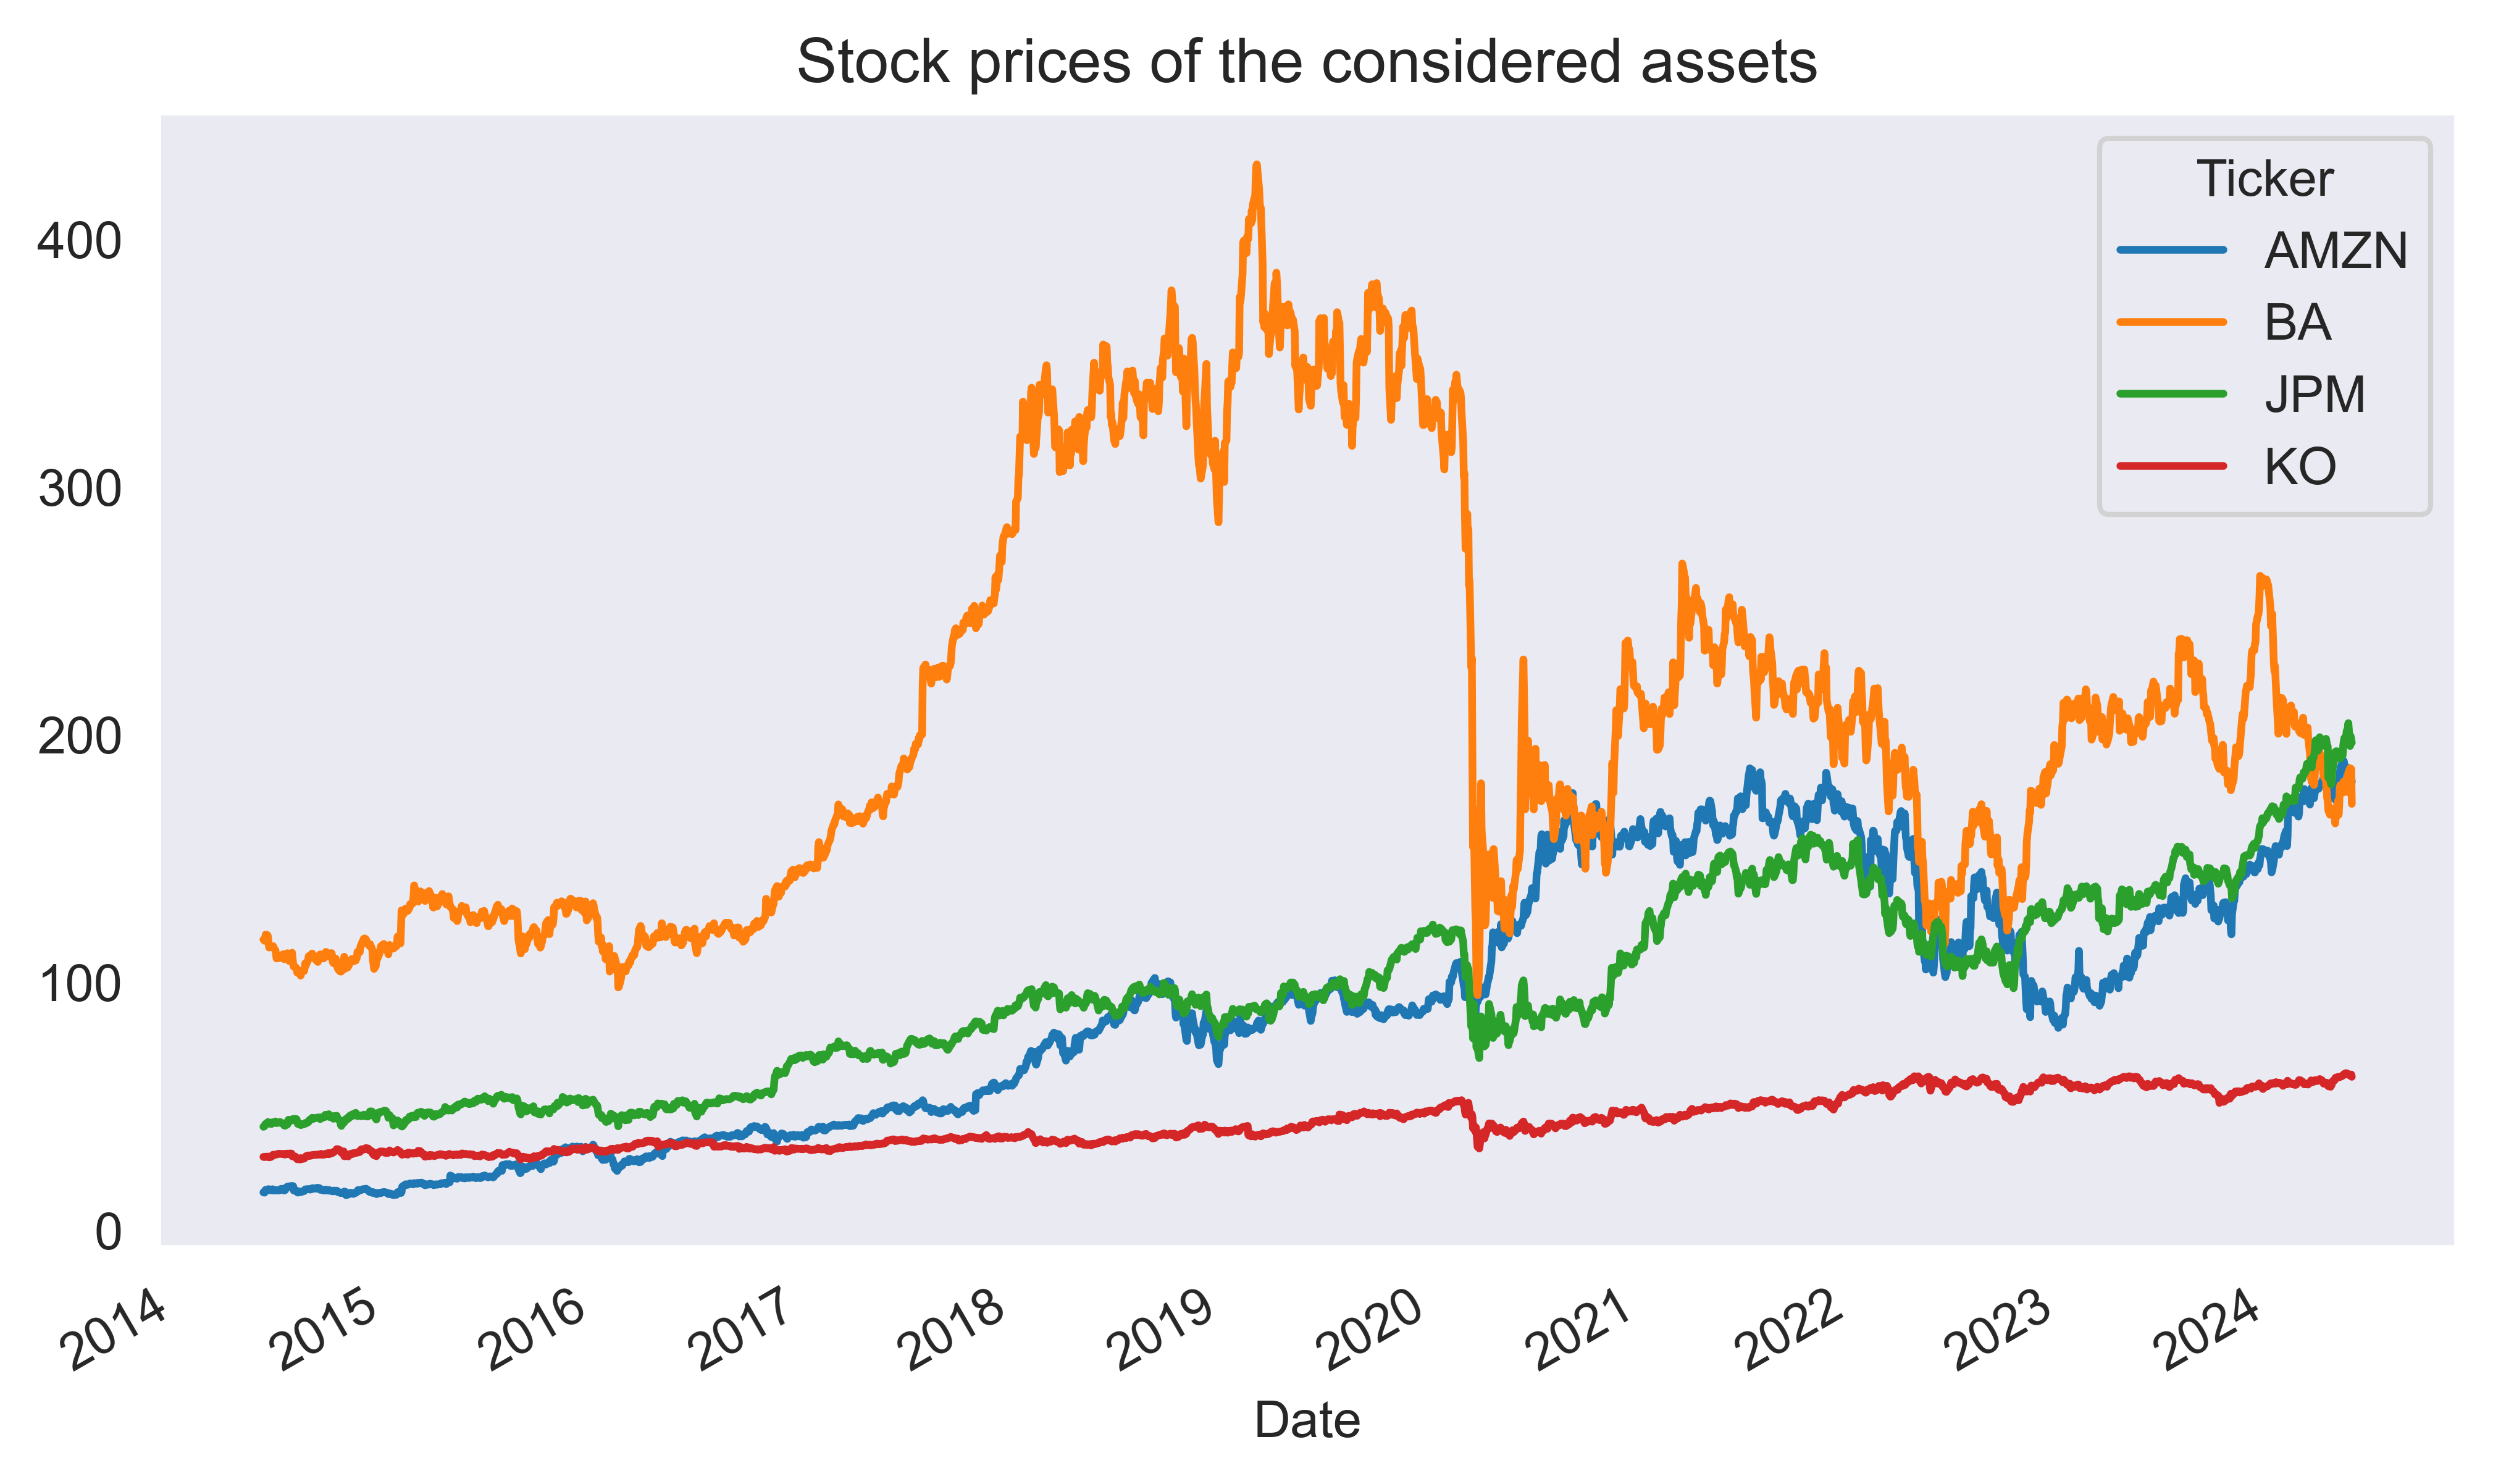

In [4]:
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')
plt.grid();

Calcoliamo rendimenti e volatilità

In [5]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * n_days # rendimenti medi annualizzati
cov_mat = returns_df.cov() * n_days # matrice di covarianza annualizzata (per i giorni e non per la radice quadrata dei giorni, perché si parla di varianza e non dev. standard)

returns_df

Ticker          AMZN        BA       JPM        KO
Date                                              
2014-06-03 -0.005343 -0.000147  0.004516  0.000489
2014-06-04 -0.001335 -0.004048  0.001439 -0.002201
2014-06-05  0.054730  0.011010  0.017062  0.002451
2014-06-06  0.018852  0.010451  0.006004  0.002446
2014-06-09 -0.006582 -0.002097  0.007899 -0.001952
...              ...       ...       ...       ...
2024-05-17  0.005827  0.010877  0.011458 -0.004580
2024-05-20 -0.006280  0.008975 -0.044973 -0.007298
2024-05-21 -0.002125 -0.009807  0.020145  0.005434
2024-05-22 -0.000109  0.008118 -0.006065  0.001431
2024-05-23 -0.011358 -0.075531 -0.007009 -0.014444

[2512 rows x 4 columns]

In [6]:
avg_returns

Ticker
AMZN    0.300547
BA      0.117459
JPM     0.191533
KO      0.089927
dtype: float64

In [7]:
cov_mat

Ticker      AMZN        BA       JPM        KO
Ticker                                        
AMZN    0.107474  0.037378  0.026005  0.013237
BA      0.037378  0.157876  0.059980  0.028807
JPM     0.026005  0.059980  0.072653  0.022531
KO      0.013237  0.028807  0.022531  0.031991

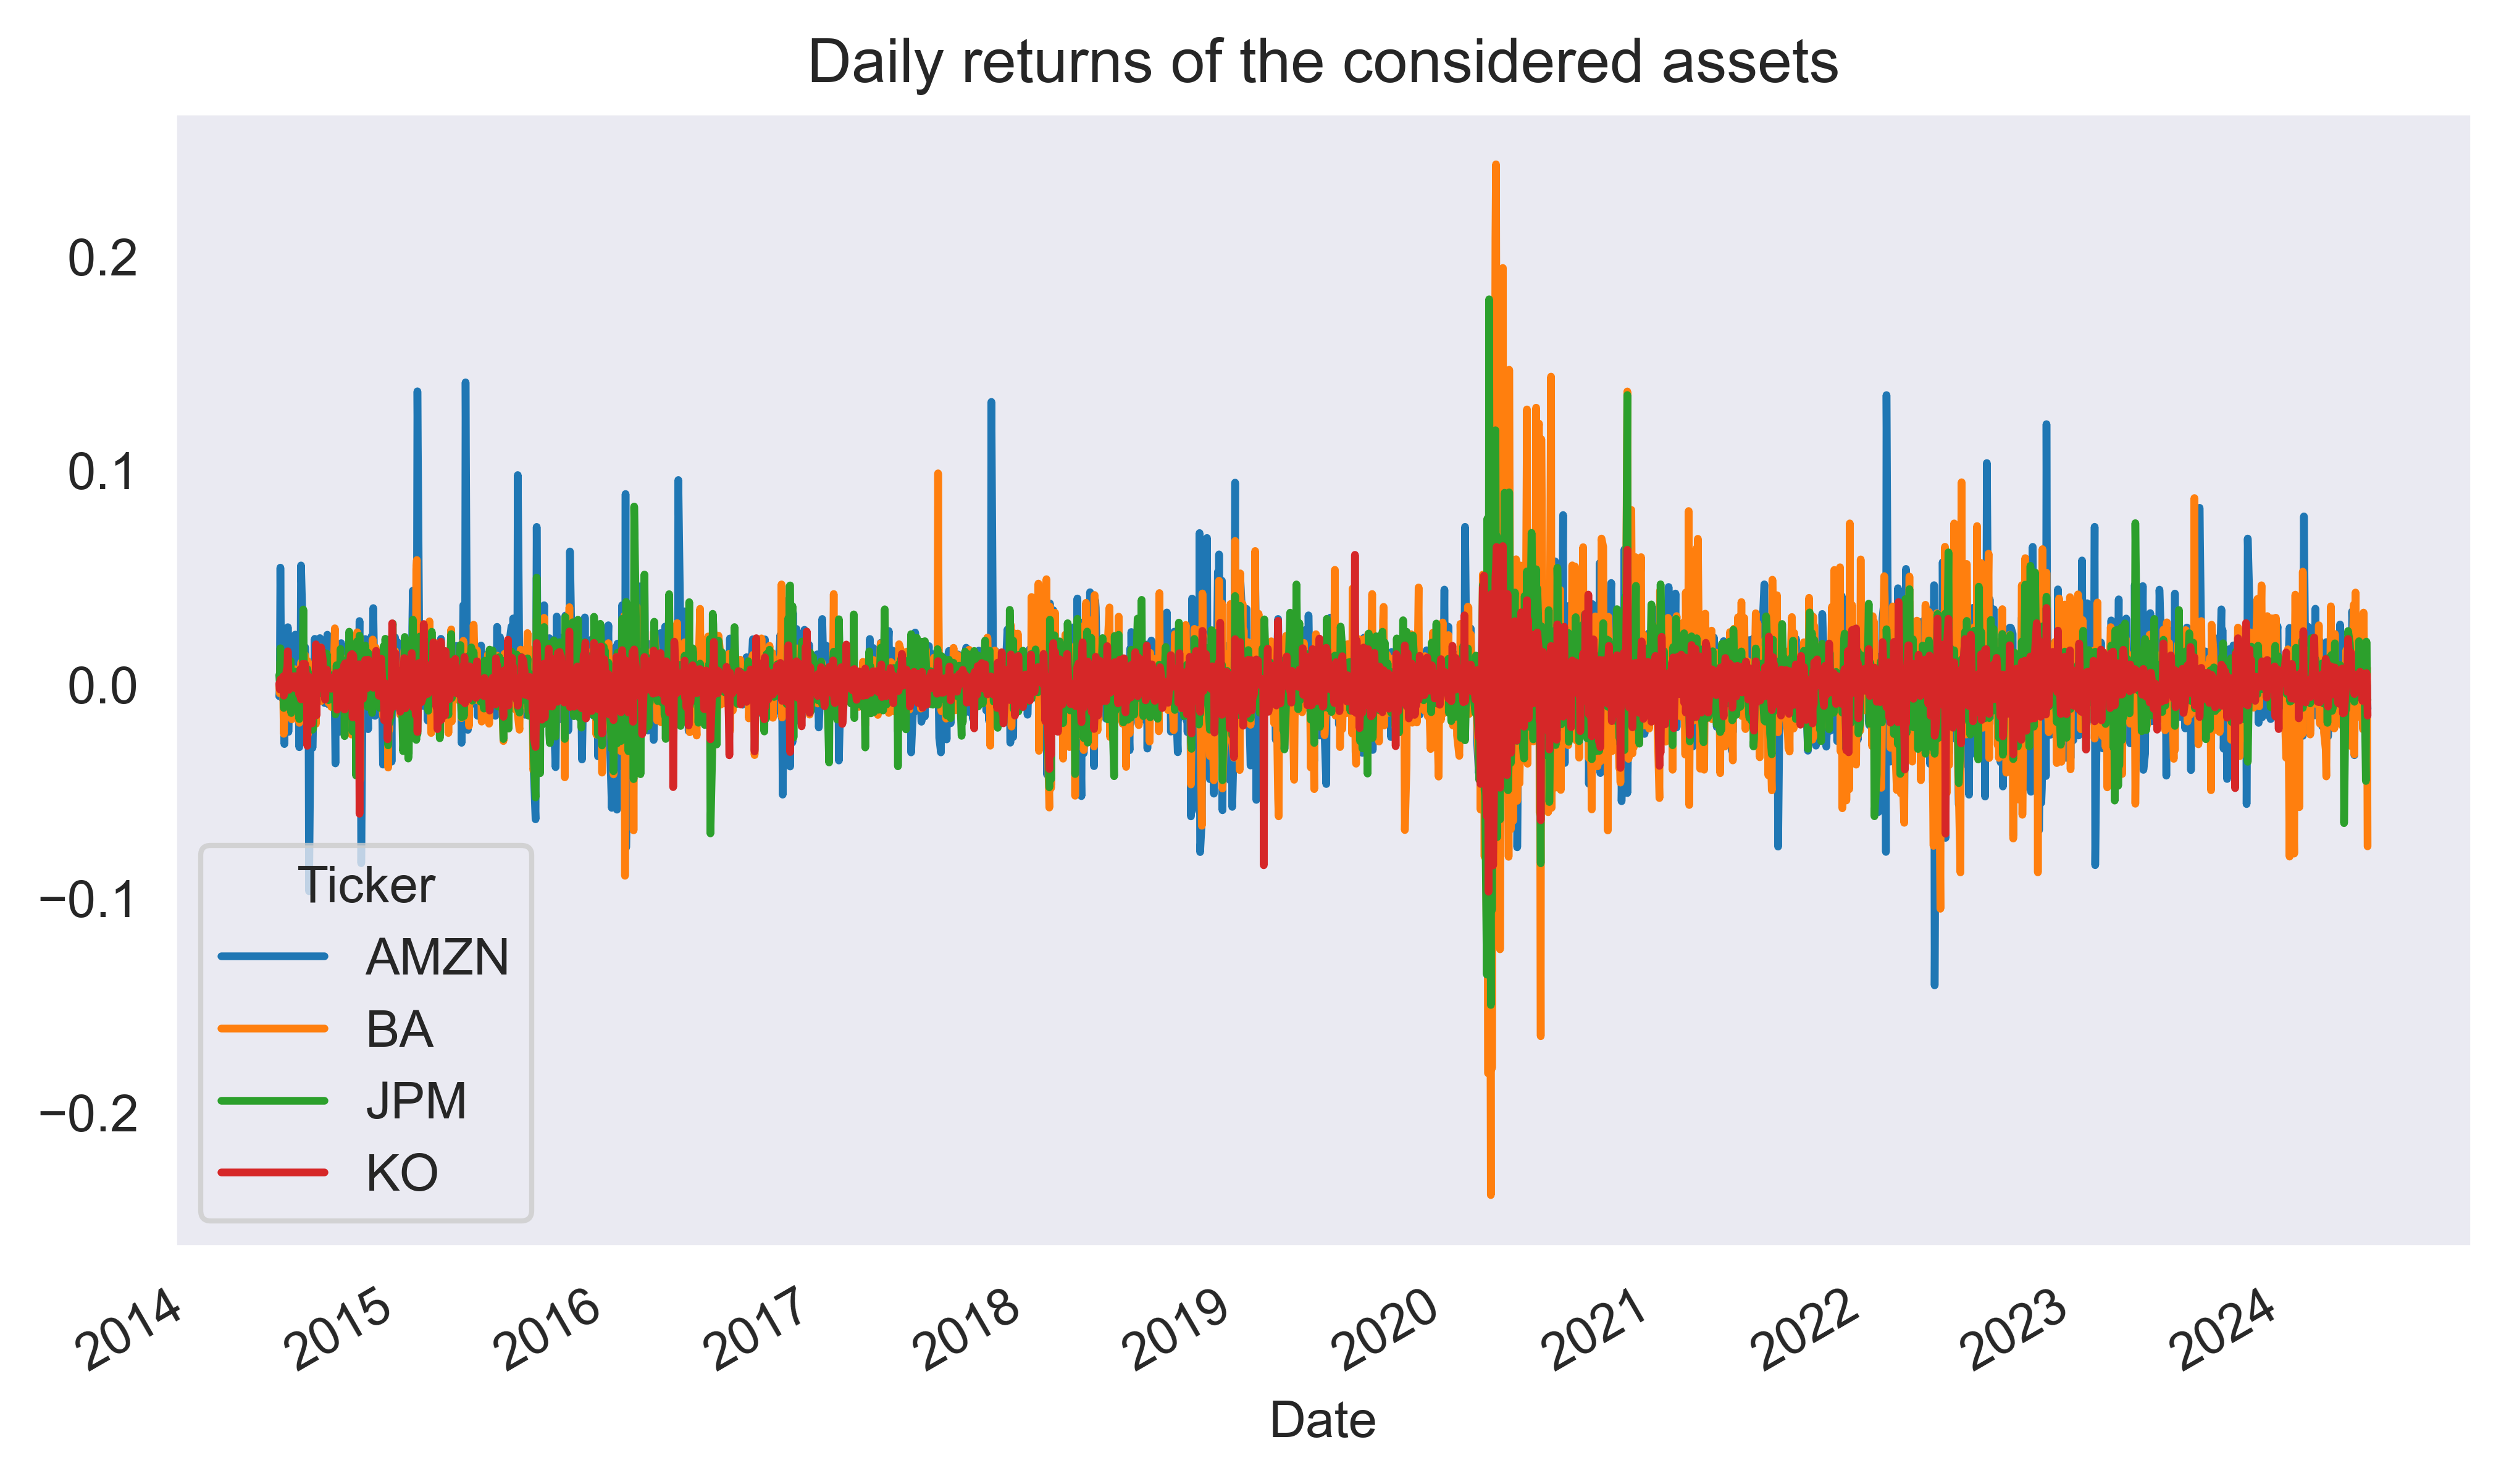

In [8]:
returns_df.plot(title='Daily returns of the considered assets')
plt.grid();

Simuliamo portafogli con pesi casuali

In [9]:
np.random.seed(42)
weights = np.random.random(size=(n_port, n_assets))
weights = weights / np.sum(weights, axis=1)[:, np.newaxis]

Con questo pezzo di codice, dopo aver impostato il seed per la generazione di numeri pseudocasuali, viene creata una matrice (array numpy bidimensionale) `weights` con `n_port` righe e `n_assets` colonne, interamente riempita con numeri casuali ciascuno compreso tra 0 e 1. <br>
Dopodiché viene fatta la somma dei pesi lungo le righe, dando vita ad un array (array numpy monodimensionale) di somme (una somma per riga, ciascuna riga corrisponde ad un portafoglio, quindi una somma per ogni portafoglio); tale array viene ridimensionato con `[:, np.newaxis]`, che consente di passare da un array monodimensionale ad uno bidimensionale (si passa da un array ad una matrice con una sola colonna, di fatto non cambia niente ma serve per rendere compatibili le operazioni con altri array bidimensionali). <br>
Alla fine, ogni riga in `weights` viene divisa per la somma dei pesi del rispettivo portafoglio: questo consente di avere somma dei pesi pari ad 1 in tutte le righe del DataFrame. 

Facciamo un piccolo esempio:

In [10]:
pesi = np.array([[0.2, 0.3, 0.5], # la cui somma è 1.0
                    [0.1, 0.4, 0.8]]) # la cui somma è 1.3
somme = np.sum(pesi, axis=1)  # Risultato: [1.0, 1.3]
somme = somme[:, np.newaxis]  # Risultato: [[1.0], [1.3]]

pesi = pesi / somme
# Risultato (pesi normalizzati):
# [[0.2, 0.3, 0.5], 
# [0.0769, 0.3077, 0.6154]]
print(pesi)

[[0.2        0.3        0.5       ]
 [0.07692308 0.30769231 0.61538462]]


In [11]:
weights

array([[0.14102156, 0.35796222, 0.27560979, 0.22540643],
       [0.12620081, 0.1261813 , 0.04698284, 0.70063506],
       [0.2613905 , 0.30790022, 0.00895102, 0.42175826],
       ...,
       [0.24844023, 0.35095292, 0.34779874, 0.05280811],
       [0.26525555, 0.15257129, 0.28992551, 0.29224765],
       [0.12145388, 0.25651504, 0.39812299, 0.22390809]])

Calcoliamo i rendimenti di portafoglio (come prodotto vettoriale tra pesi e rendimenti)

In [12]:
portf_rtns = np.dot(weights, avg_returns) # moltiplica (prodotto tra matrici) i pesi per i rendimenti medi annualizzati

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i])))) # formula per la volatilità (deviazione standard)
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

__PER CAPIRE__: per ogni riga della matrice dei pesi (portafoglio) calcoliamo la volatilità come radice quadrata di (trasposta dei pesi * matrice di covarianza * pesi).

Come criterio per ordinare i portafogli generati utilizziamo lo Sharpe Ratio.

__NB__: qui lo Sharpe Ratio è calcolato non correttamente, a cosa normale bisognerebbe introdurre la componente risk-free.

Creiamo un DataFrame con tutti i dati calcolati.

In [13]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [14]:
portf_results_df.head()

returns  volatility  sharpe_ratio
0  0.157488    0.235438      0.668914
1  0.124755    0.176684      0.706092
2  0.154368    0.212240      0.727327
3  0.231522    0.244219      0.948010
4  0.168794    0.234488      0.719842

Creazione della frontiera efficiente


In [15]:
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

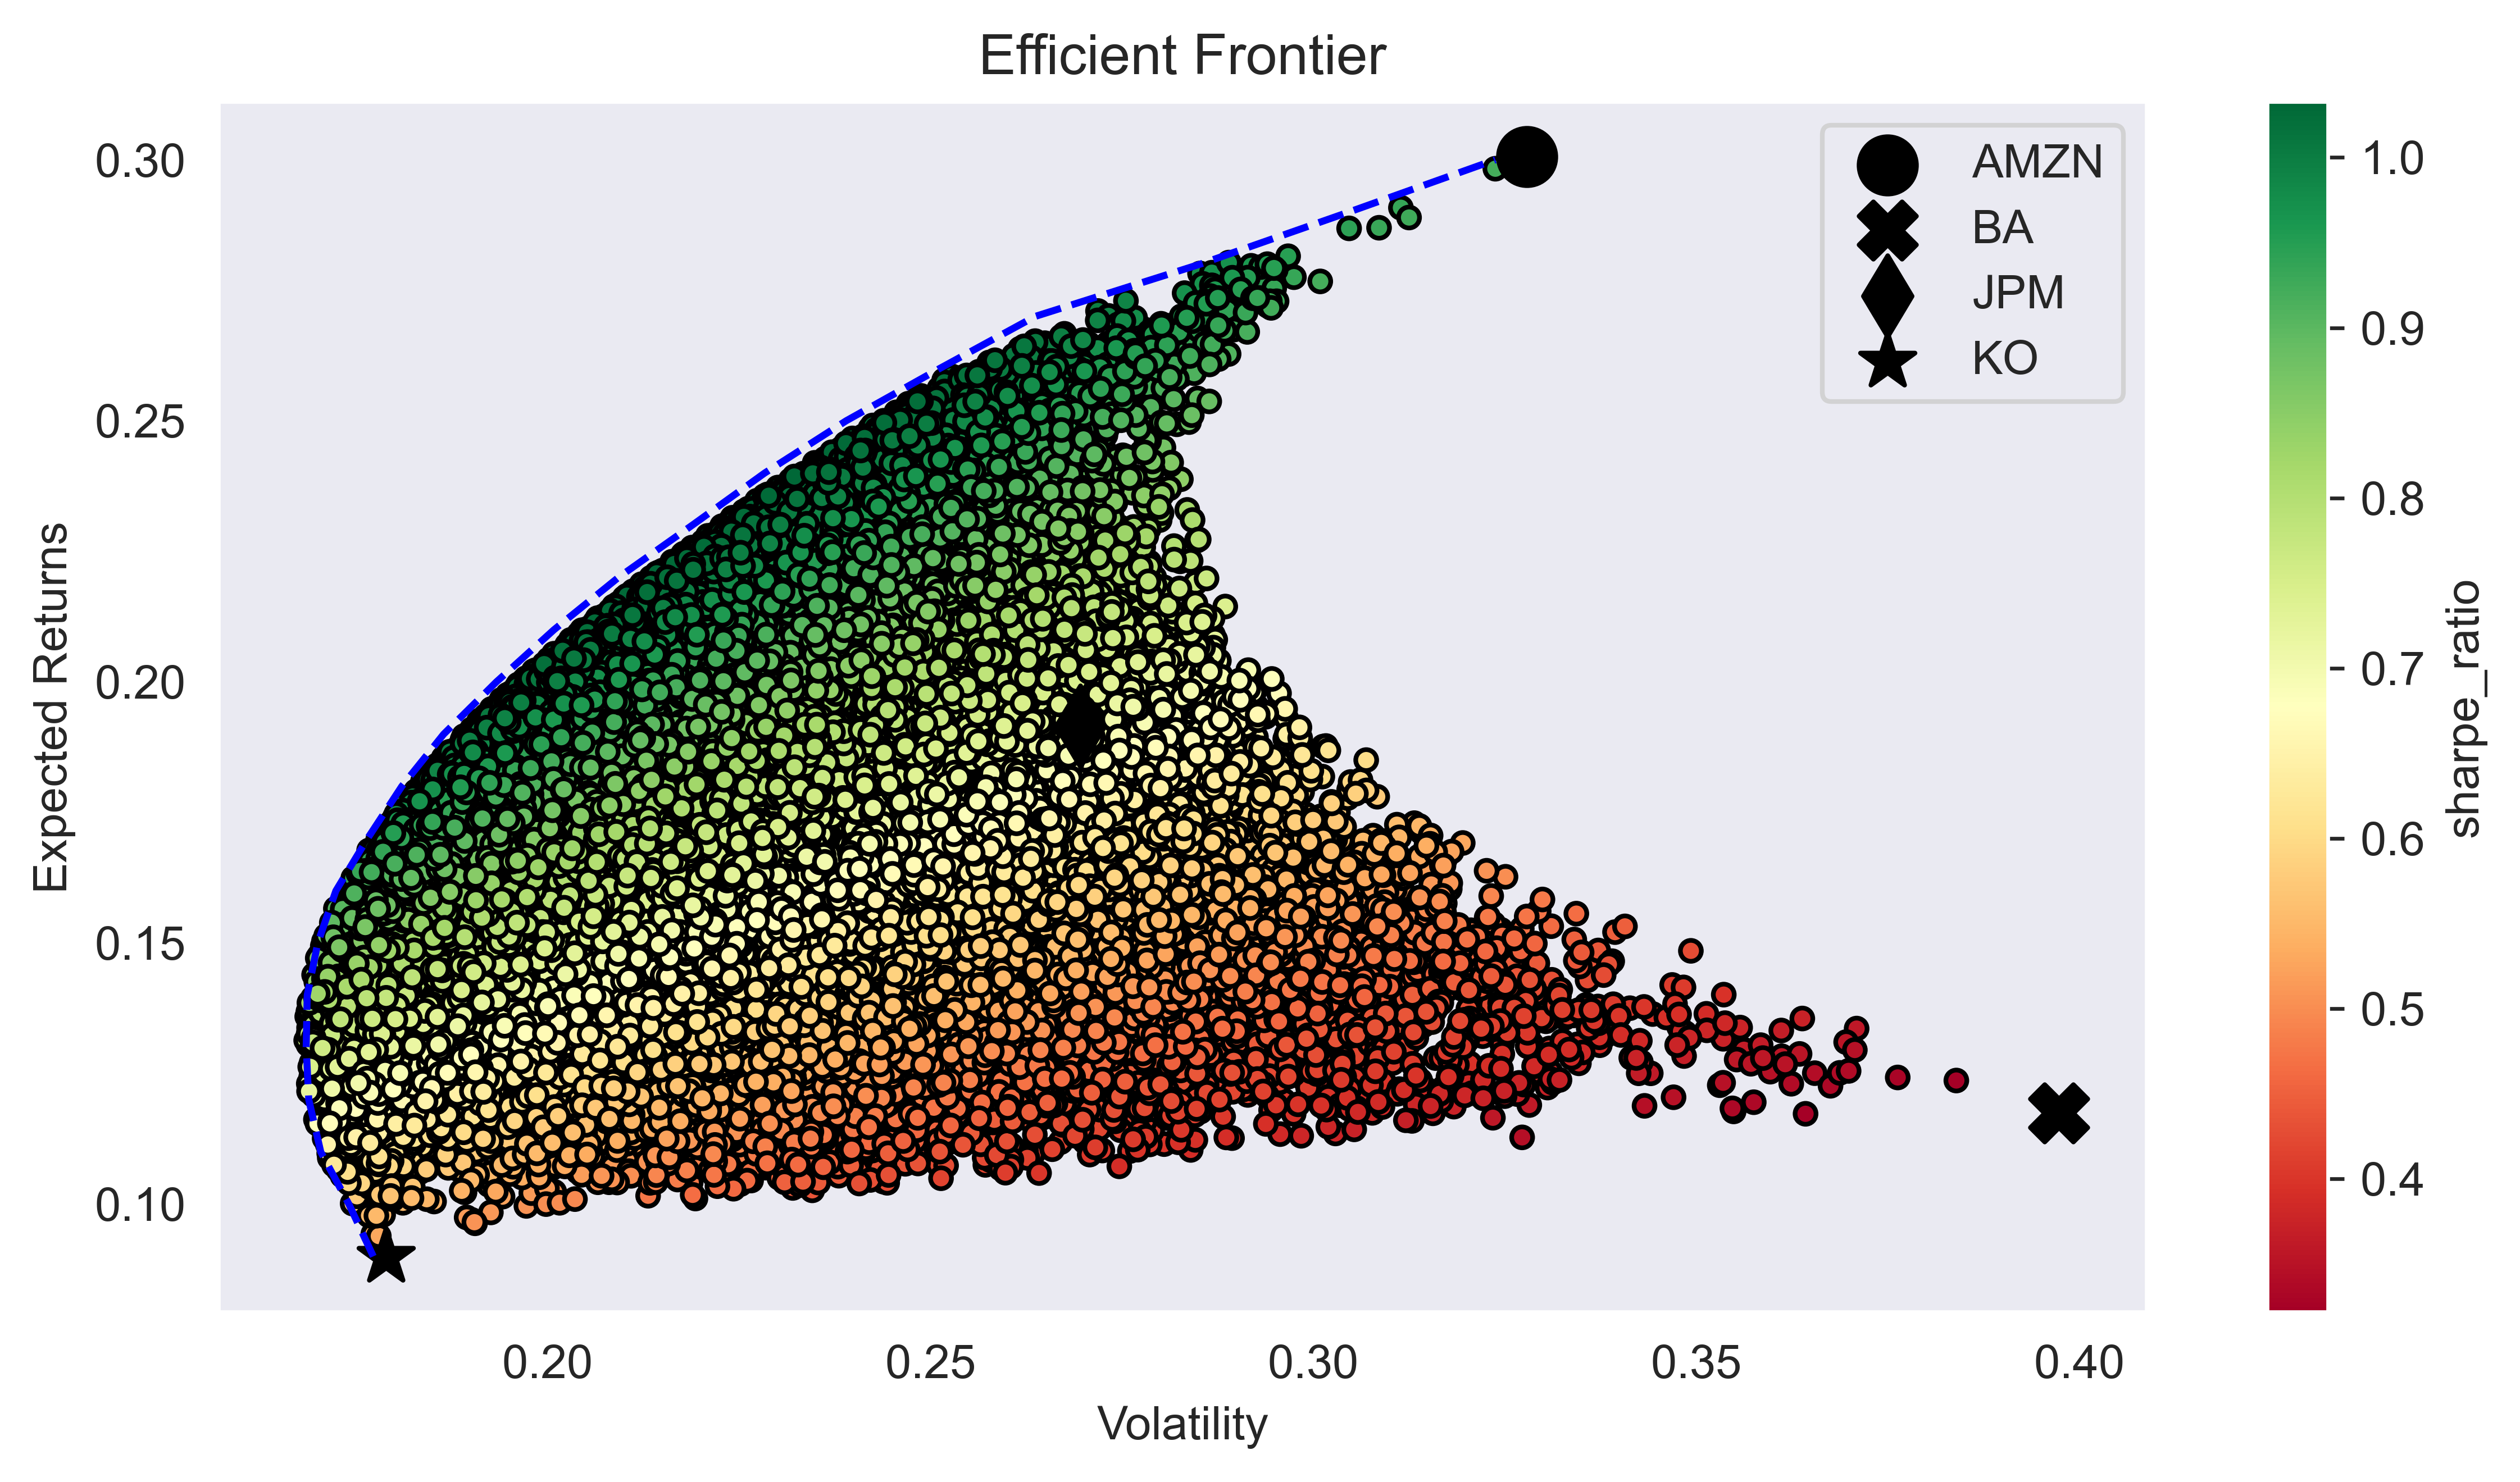

In [16]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=risky_assets[asset_index])
ax.legend()

plt.tight_layout()
plt.grid()
plt.show()


#### Ricerca del portafoglio con l'indice di Sharpe più alto

In [17]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [18]:
print('Maximum Sharpe Ratio portfolio')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(risky_assets, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)


Maximum Sharpe Ratio portfolio
Performance
returns: 23.14% volatility: 22.41% sharpe_ratio: 103.26% 
Weights
AMZN: 51.11% BA: 0.03% JPM: 33.33% KO: 15.53% 

In [19]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(risky_assets, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 13.14% volatility: 16.85% sharpe_ratio: 77.97% 
Weights
AMZN: 12.64% BA: 0.04% JPM: 14.56% KO: 72.76% 

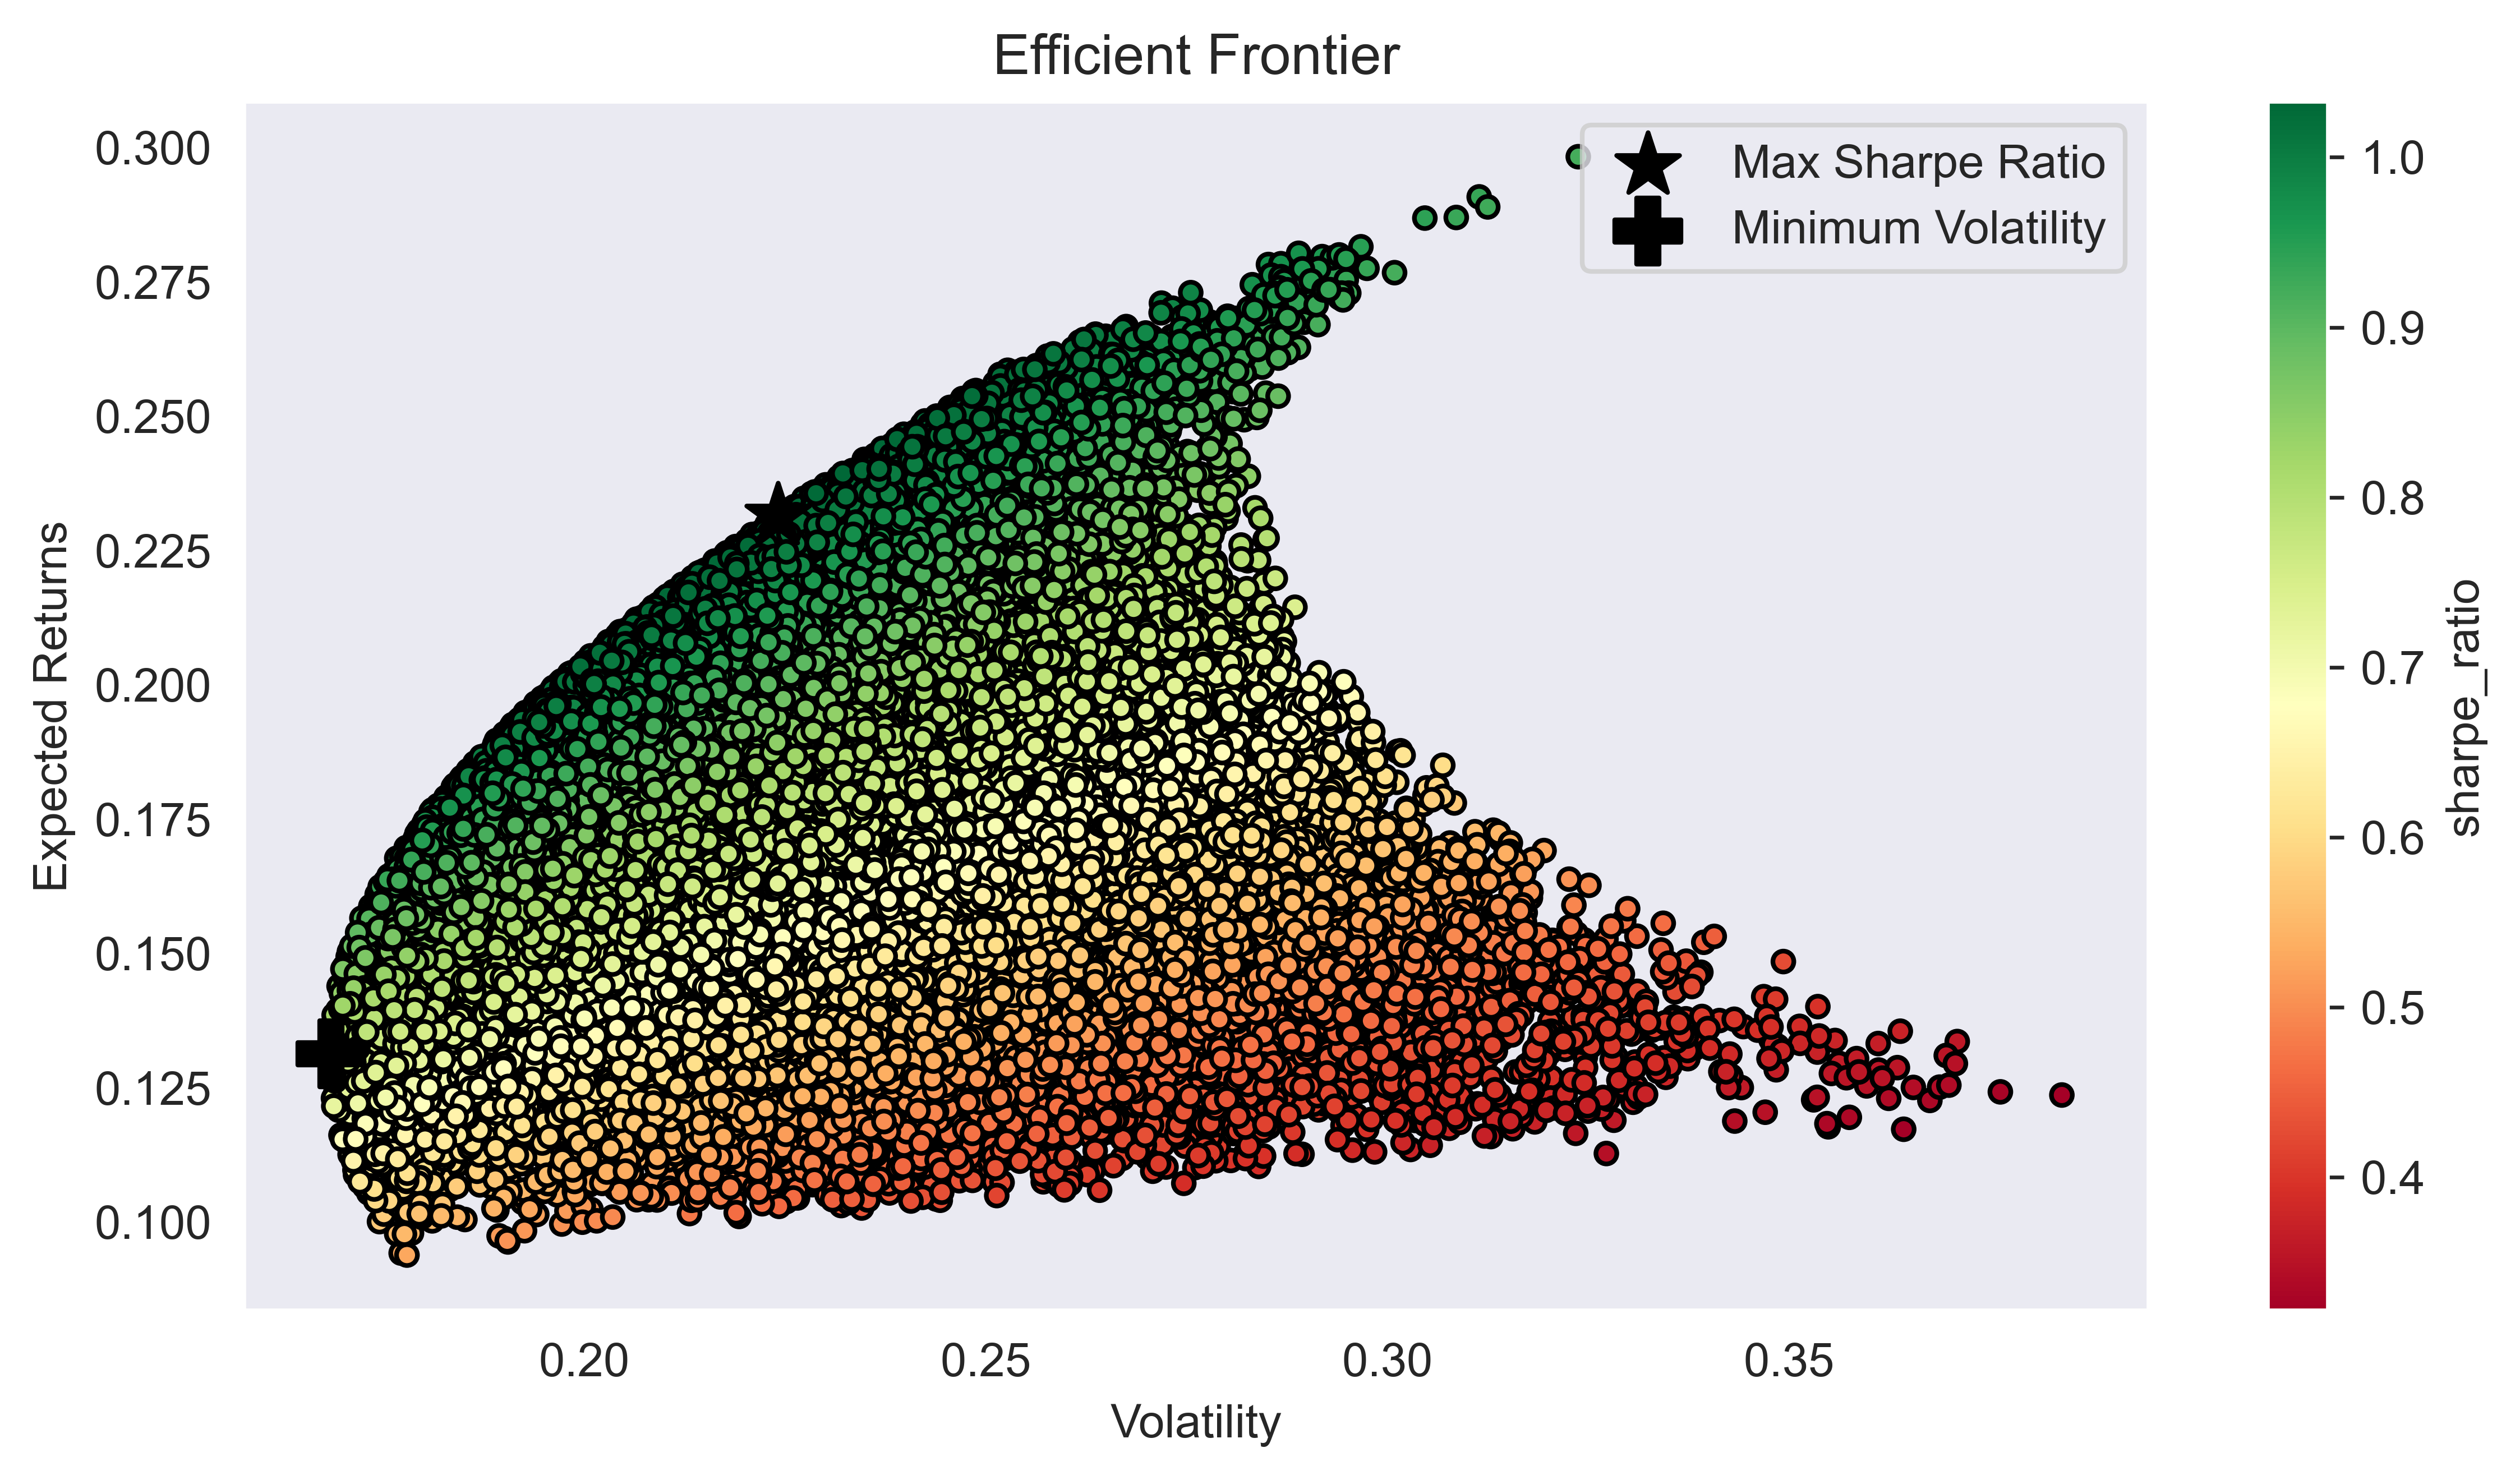

In [20]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.grid()
plt.show()

### Frontiera efficiente con la funzione di ottimizzazione di scipy

In [21]:
import numpy as np
import scipy.optimize as sco

In [22]:
def get_portf_rtn(w, avg_rtns): # rendimento del portafoglio
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat): # volatilità del portafoglio
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [23]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, # minimizza la volatilità 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [24]:
rtns_range = np.linspace(-0.22, 0.32, 200)

In [25]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

In [26]:
vols_range = [x['fun'] for x in efficient_portfolios]

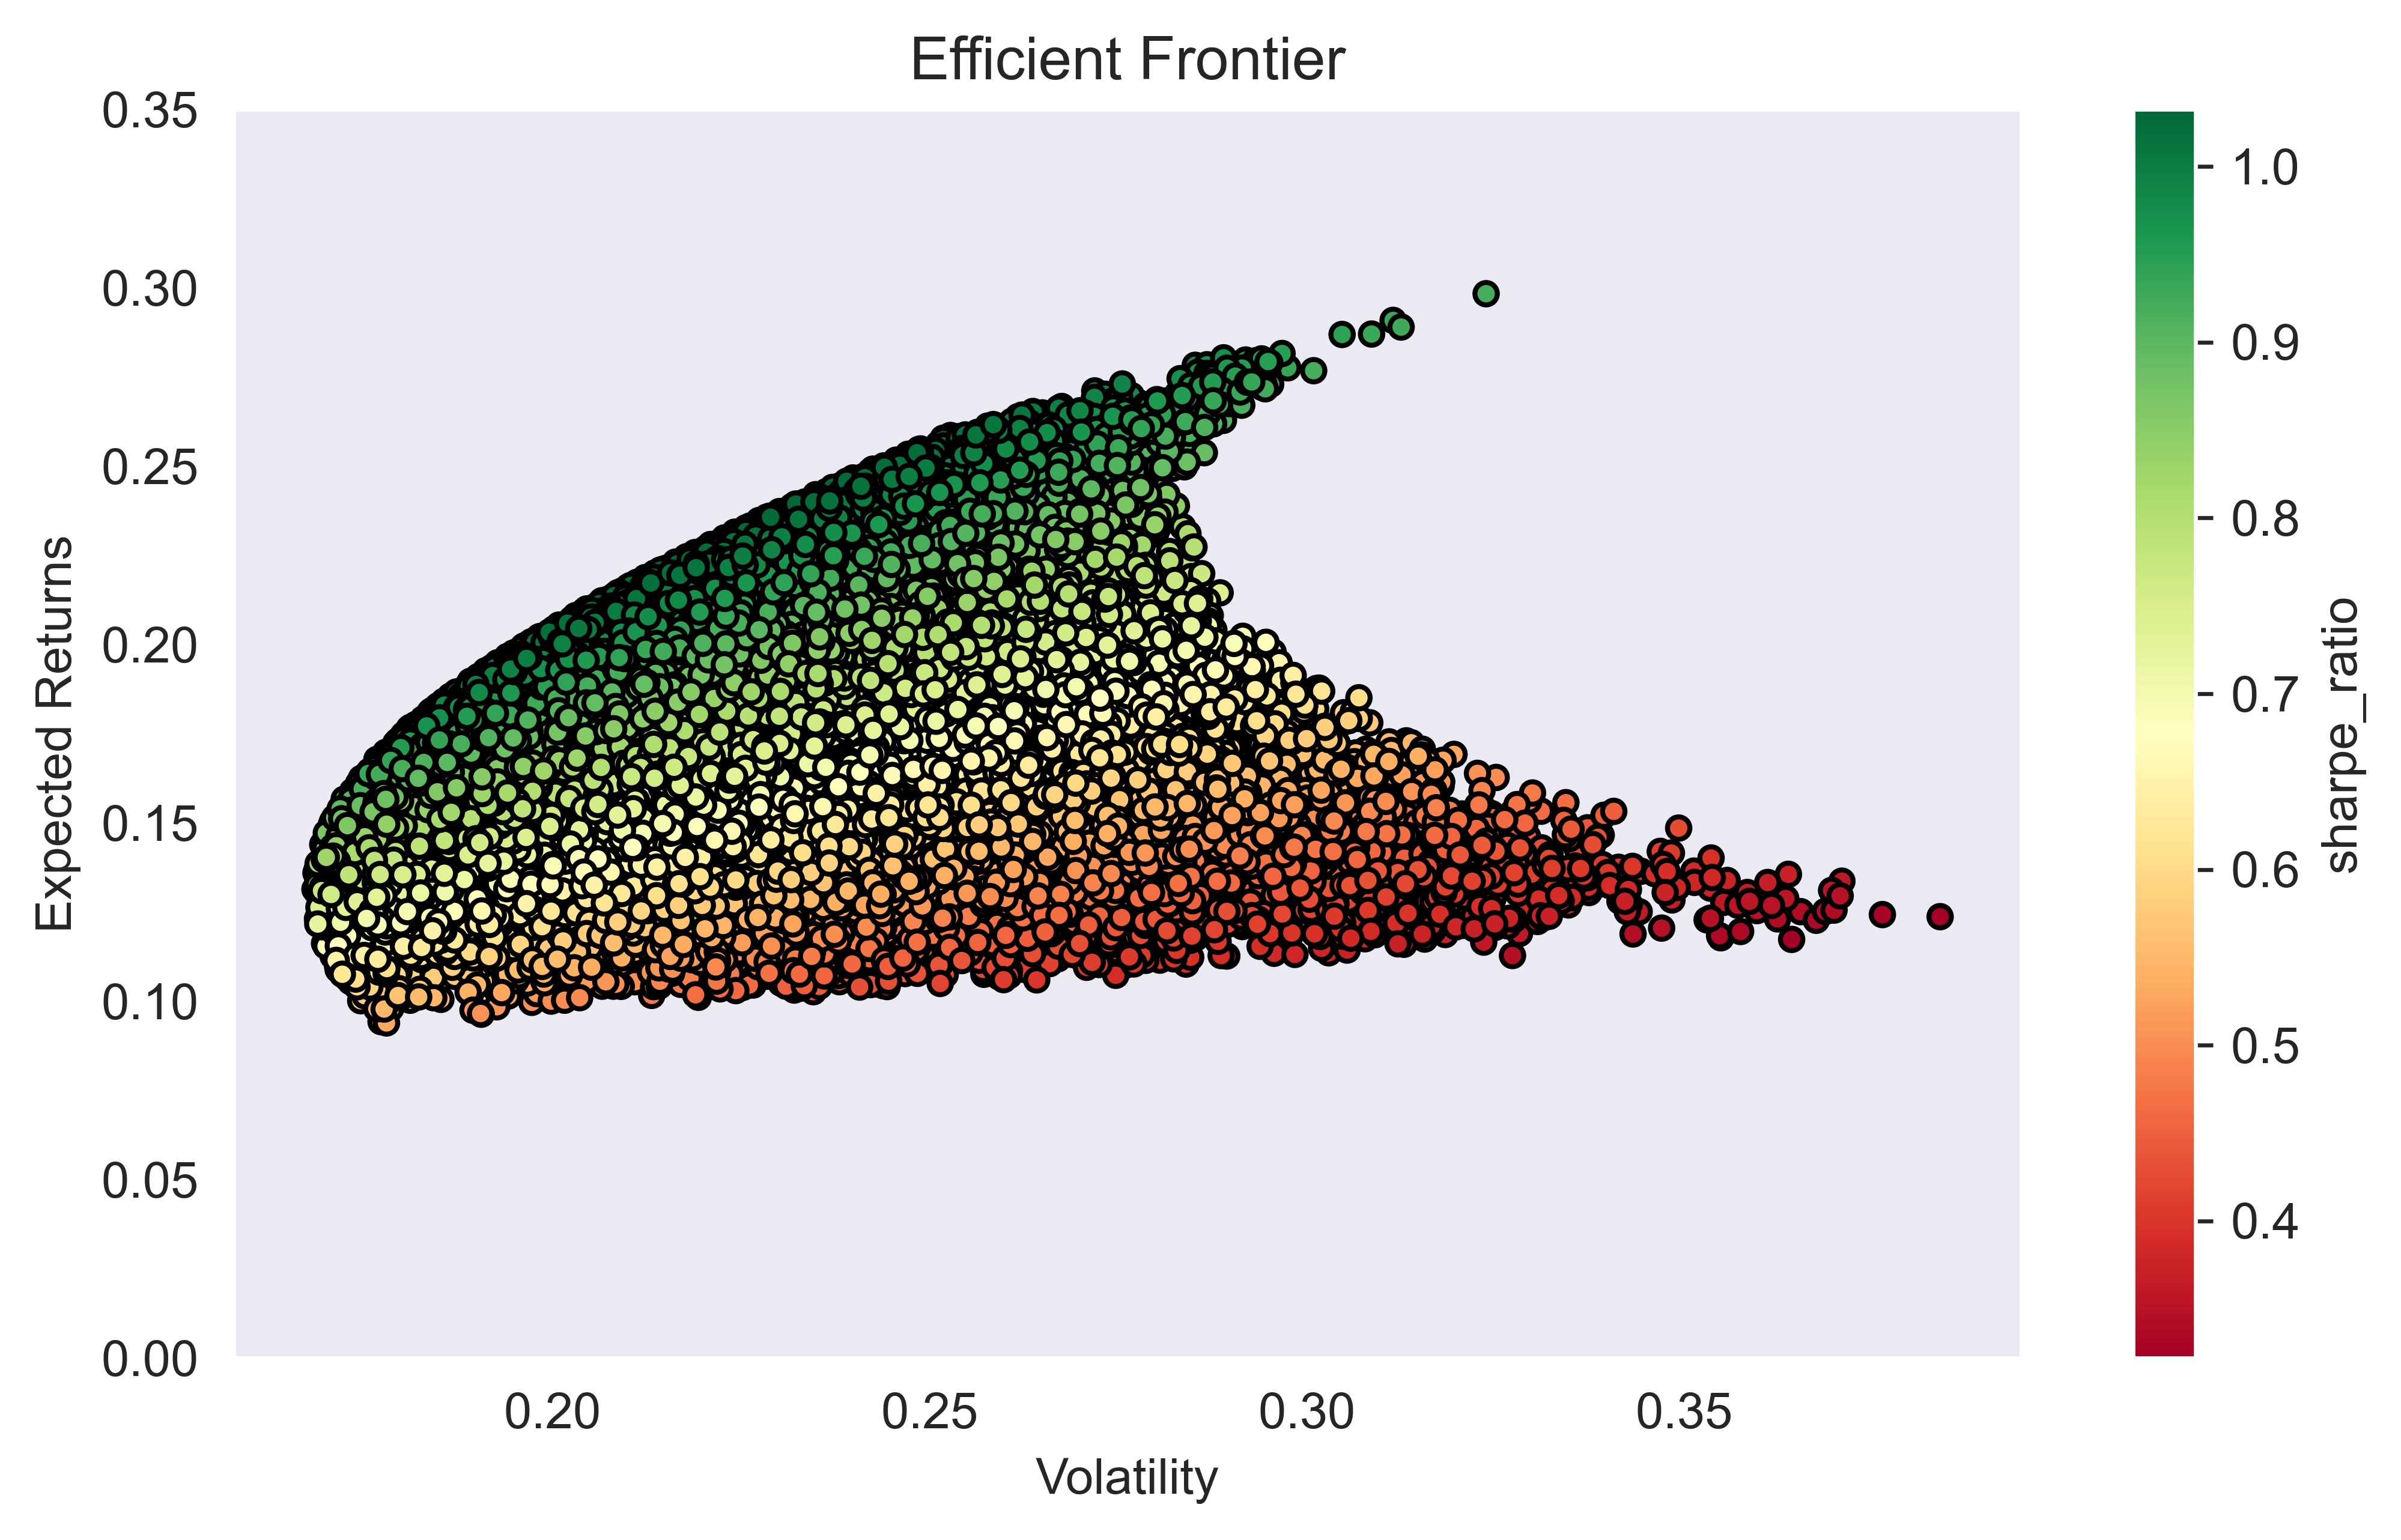

In [27]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
#ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

#plt.ylim(0.25,0.45)
plt.ylim(0,0.35)
plt.grid()
plt.show()

Portafoglio con minima volatilità

In [28]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': 0.13005025125628142,
 'Volatility': 0.16815987843923613,
 'Sharpe Ratio': 0.7733726526406507}

Sommario dei risultati

In [29]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(risky_assets, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: 13.01% Volatility: 16.82% Sharpe Ratio: 77.34% 
Weights
AMZN: 14.15% BA: 0.00% JPM: 10.15% KO: 75.70% 

Ricerca del portafoglio con il massimo Sharpe ratio

Funzione obiettivo

In [30]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

Ricerca del portafoglio ottimale

In [31]:
n_assets = len(avg_returns)
RF_RATE = 0.04

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [32]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

{'Return': 0.25828577948609405,
 'Volatility': 0.25211610914781873,
 'Sharpe Ratio': 0.865814486126749}

In [33]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(risky_assets, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 25.83% Volatility: 25.21% Sharpe Ratio: 86.58% 
Weights
AMZN: 61.23% BA: 0.00% JPM: 38.77% KO: 0.00% 

### Ottimizzazione da un altro punto di vista: l'avversione al rischio

In [34]:
import cvxpy as cp

In [35]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

In [36]:
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function, 
                     [cp.sum(weights) == 1, weights >= 0])

In [37]:
N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for i in range(N_POINTS):
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

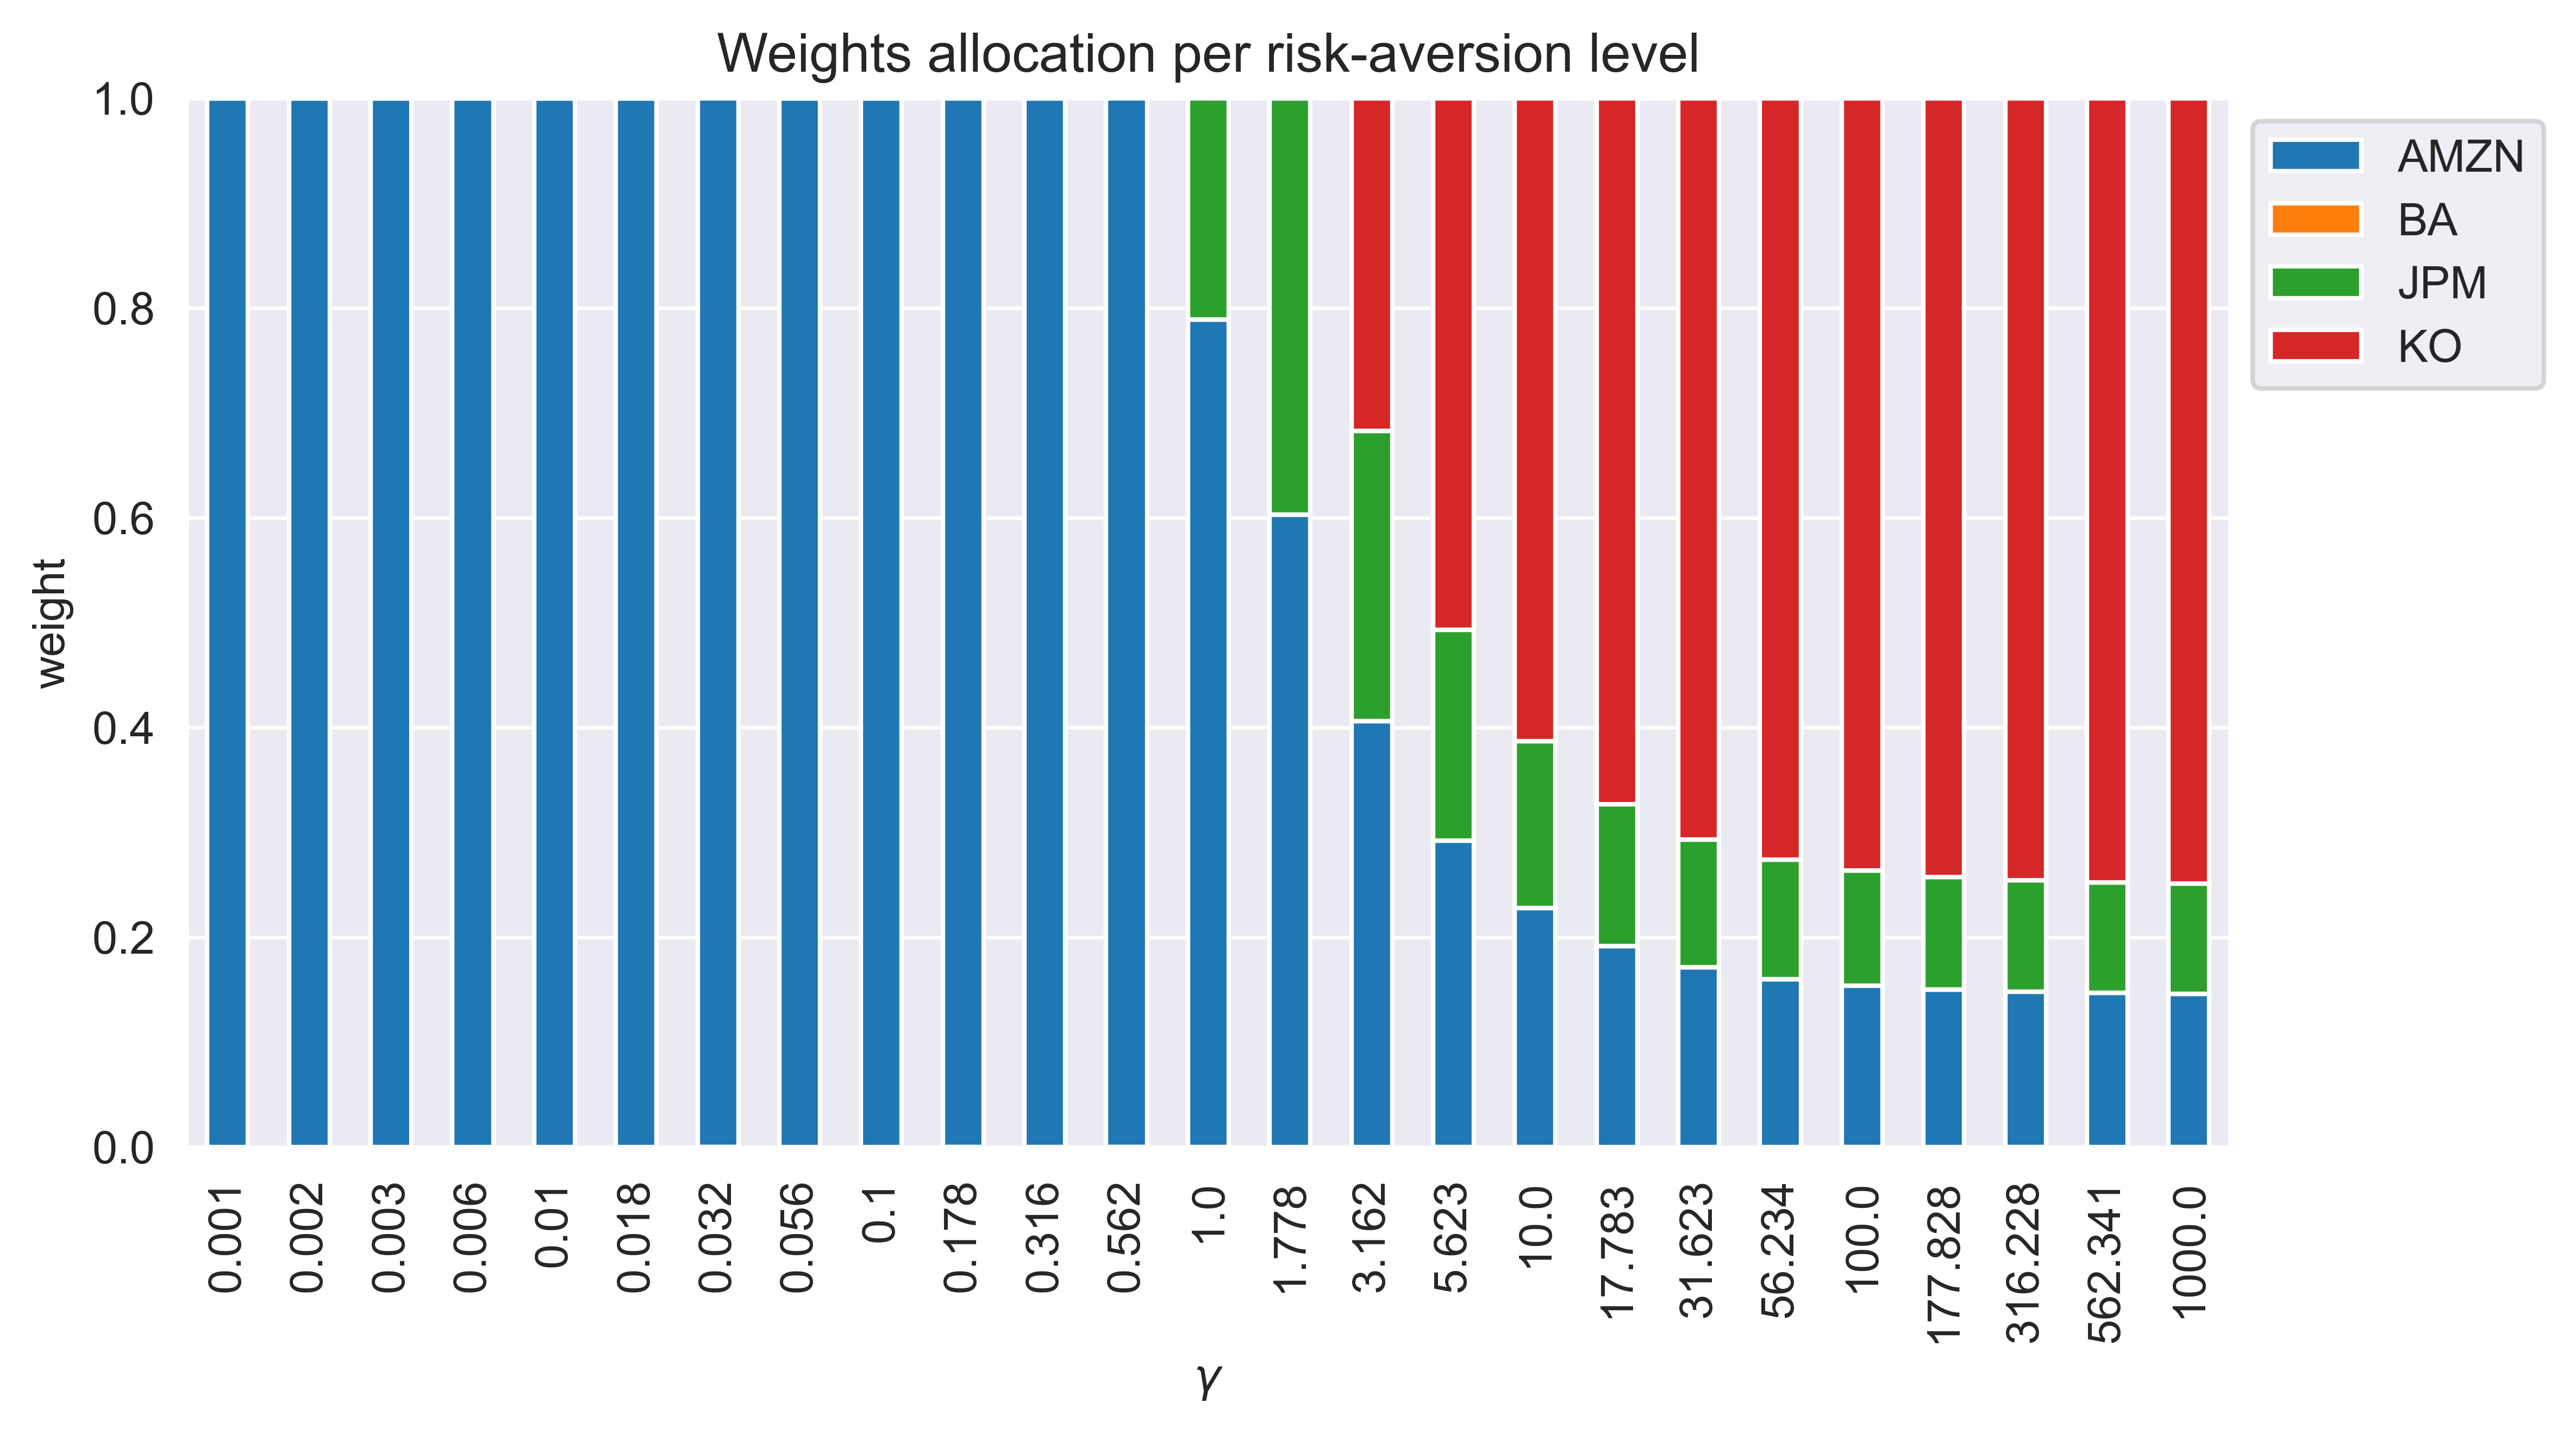

In [38]:
weights_df = pd.DataFrame(weights_ef, 
                          columns=risky_assets, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True) 
ax.set(title='Weights allocation per risk-aversion level',
       xlabel=r'$\gamma$', 
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()

plt.show()

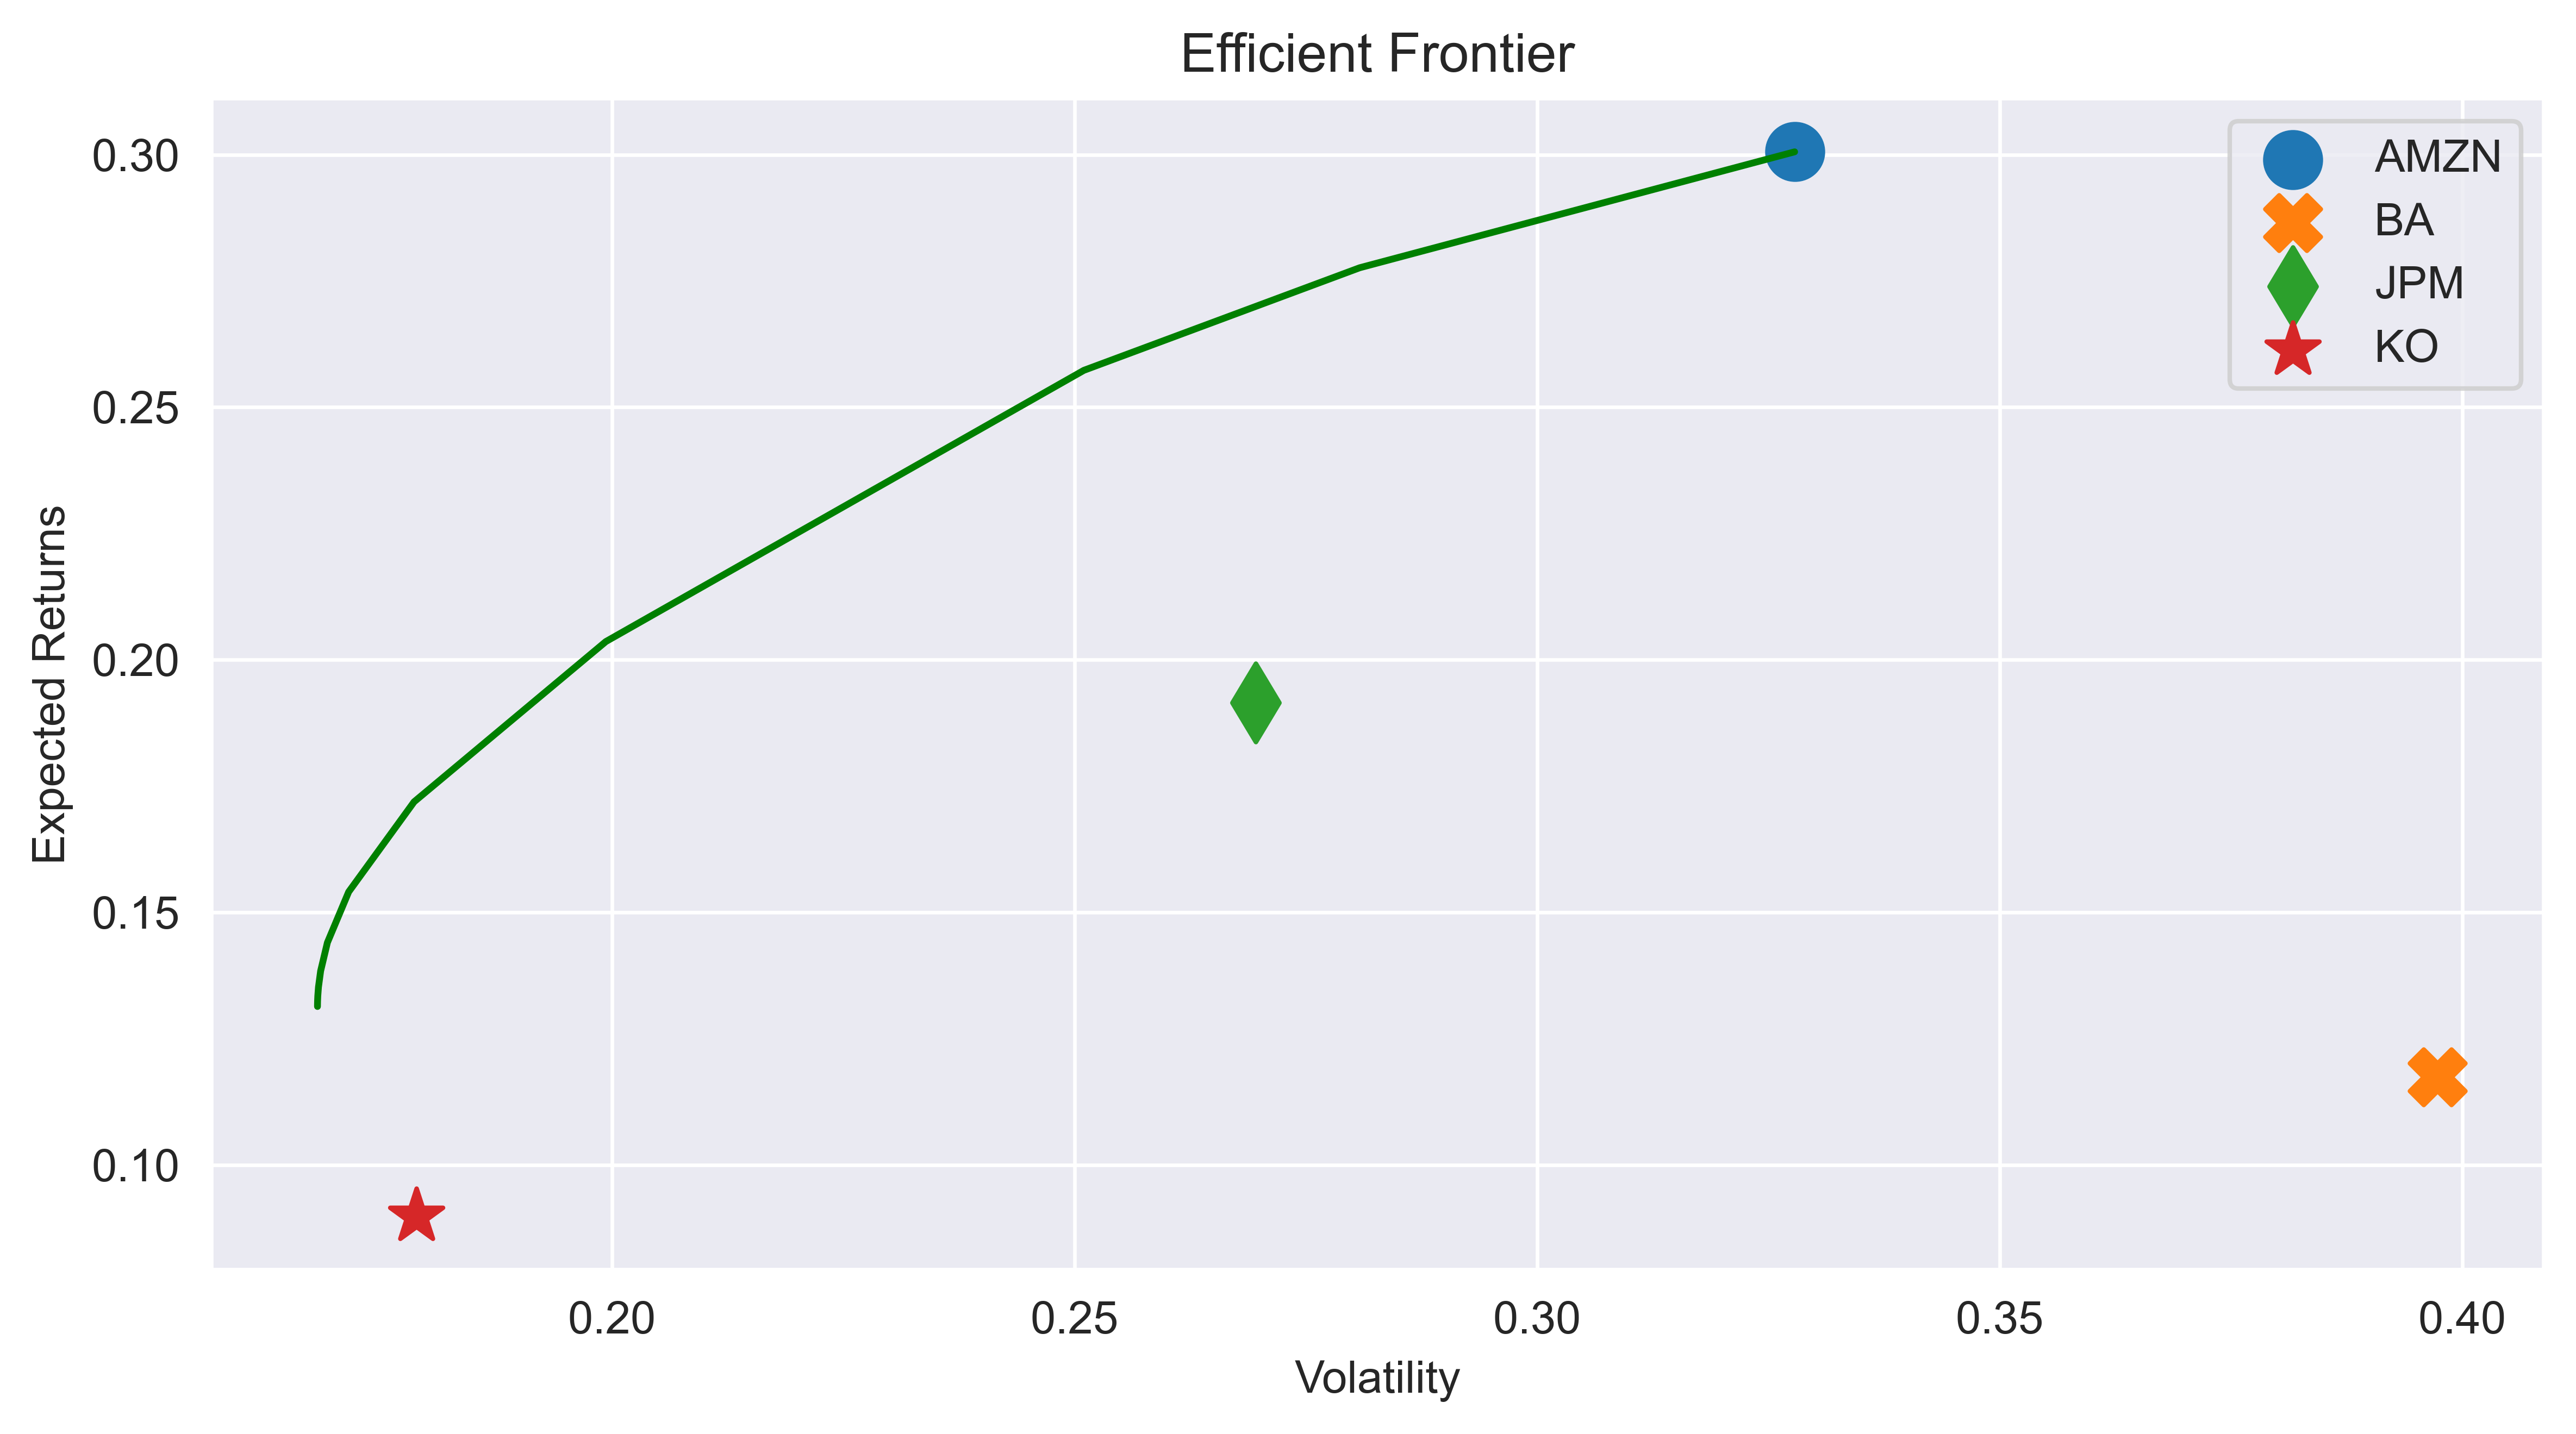

In [39]:
#MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                 marker=MARKS[asset_index], 
                 label=risky_assets[asset_index],
                 s=150)
ax.set(title='Efficient Frontier',
       xlabel='Volatility', 
       ylabel='Expected Returns', )
ax.legend()

plt.tight_layout()

plt.show()